In [1]:
import os
import datetime
import requests
import numpy as np
import pandas as pd
from math import ceil
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
from collections import defaultdict

def lift(r_S, h1, h2):
    N = r_S.shape[0]-1 # truncates NaN at start of series
    out = np.zeros((1+((N-h1+1) - ((N-h1)%h2)-1)//h2, h1), dtype=np.float32)
    for idx, s_idx in enumerate(np.arange((N-h1)%h2, N-h1+1, h2)):
        e_idx = s_idx + h1
        out[idx] = r_S[s_idx+1:e_idx+1]
    return out

def delift(labels, r_S, h1, h2):
    N = r_S.shape[0]-1 # truncates NaN at start of series
    # out = np.zeros((1+((N-h1+1) - ((N-h1)%h2)-1)//h2, h1), dtype=np.float32)
    n_labels = ceil(h1/h2)
    out = np.zeros((N+1, n_labels)) * np.nan
    label_id = 0
    for idx, s_idx in enumerate(np.arange((N-h1)%h2, N-h1+1, h2)):
        e_idx = s_idx + h1
        out[s_idx+1:e_idx+1, label_id] = labels[idx]
        label_id = (label_id+1)%n_labels
    return out

def extract_percentiles(r_S, h1, h2, lp=1, up=99):
    N = r_S.shape[0]-1
    min_ = np.percentile(r_S[((N-h1)%h2)+1:], 1)
    max_ = np.percentile(r_S[((N-h1)%h2)+1:], 99)
    return min_, max_ 

def extract_empirical_measures(l_r_S, bins, h1):
    l_r_S = l_r_S.reshape(l_r_S.shape[0], l_r_S.shape[1], 1)
    K = np.zeros((l_r_S.shape[0], bins.shape[1]))
    for idx in np.arange(l_r_S.shape[0]):
        K[idx] = (l_r_S[idx] < bins).sum(0)
    return K/h1

def calc_wasserstein_barycenter(K_ss):
    n_bins = K_ss.shape[1]
    a = np.median(K_ss, 0)
    bins = np.linspace(0, 1, n_bins)
    u_hat = ((a.reshape(n_bins, 1) >= (np.linspace(0, 1, n_bins)).reshape(1,-1)).sum(1))/n_bins
    return u_hat


In [12]:
l_r_S[0]

(79,)

In [2]:
spy_df = yf.Ticker('SPY').history(period="max")
spy_df['Returns'] = np.nan
spy_df['Returns'].values[1:] = (spy_df['Close'].values[1:] - spy_df['Close'].values[:-1])/spy_df['Close'].values[:-1]
spy_df['LOGRET_1'] = spy_df.ta.log_return()

<AxesSubplot:xlabel='Date'>

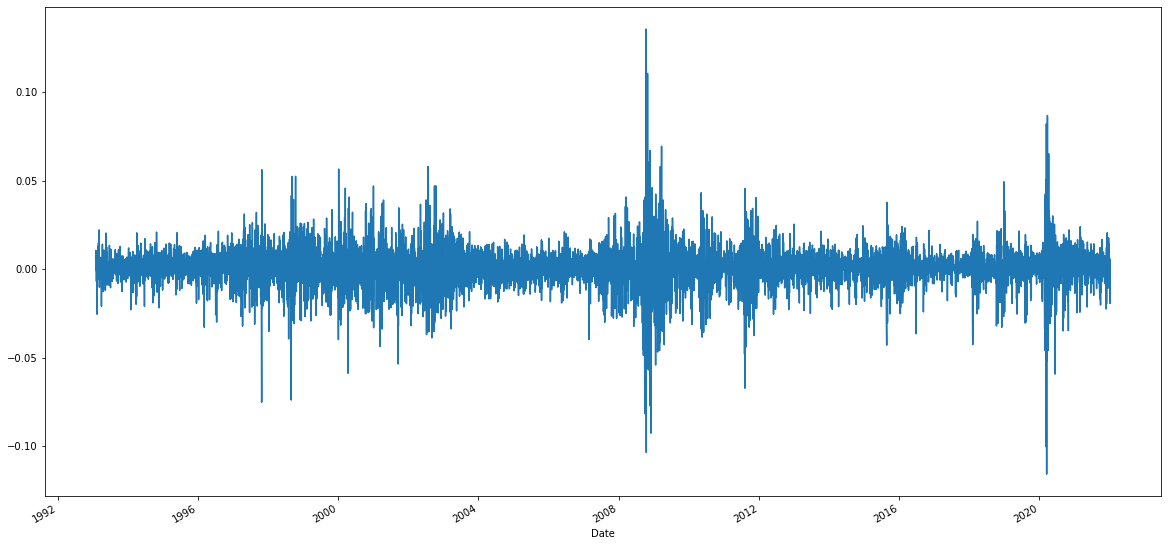

In [4]:
spy_df['LOGRET_1'].plot(figsize=(20,10))

In [64]:
# Maybe the actual way?
# p=1
# x = np.sort(l_r_S[0])
# y = np.sort(l_r_S[100])
# cz = np.linspace(1/h1, 1, h1)
# cba = np.repeat(cz, 2)
# h = np.diff(np.hstack([0, cba]))
# bins = cz + 1e-10 # small tolerance to avoid rounding errors and enforce right continuity
# index_qx = np.digitize(cba, bins, right=True)    # right=True becouse quantile function is 
# qx = x[index_qx] # quantile funciton F^{-1}      
# bins = cz + 1e-10 
# index_qy = np.digitize(cba, bins, right=True)    # right=True becouse quantile function is 
#                                                  # right continuous
# qy = y[index_qy] # quantile funciton G^{-1}
# ot_cost = np.sum((qx - qy)**p * h)


/tmp/ipykernel_5975/1349841587.py:29: RuntimeWarning: Mean of empty slice
  mu_label = np.nanmean(md_label, 1)


(array([480., 121.]), array([0, 1, 2]), <BarContainer object of 2 artists>)

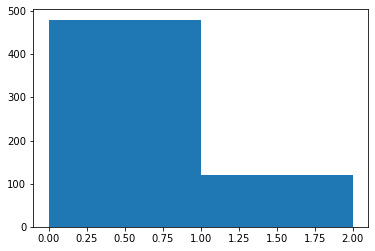

In [6]:
h1 = 79
h2 = 12
l_r_S = lift(spy_df['LOGRET_1'].values[1:], h1, h2)
min_, max_ = extract_percentiles(spy_df['LOGRET_1'].values, h1, h2, lp=1, up=99)
n_bins = 25
bins_ = np.linspace(min_, max_, n_bins).reshape(1, n_bins)
K = extract_empirical_measures(l_r_S, bins_, h1)
L = []
k = 2
delta = 1*10**-7
centroids = K[np.random.choice(np.arange(K.shape[0]), size=k, replace=False)]
cluster_assigns = np.zeros(K.shape[0])
for idx, uj in enumerate(K):
    cluster_assigns[idx] = np.argmin(np.abs(uj - centroids).sum(1)/n_bins)
centroids_new = np.stack([calc_wasserstein_barycenter(K[cluster_assigns==c]) for c in range(k)])
loss = np.sum(np.abs(centroids_new - centroids).sum(1)/n_bins)
L.append(loss)    
for itrn in range(100):
    centroids = centroids_new
    cluster_assigns = np.zeros(K.shape[0])
    for idx, uj in enumerate(K):
        cluster_assigns[idx] = np.argmin(np.abs(uj - centroids).sum(1)/n_bins)
    centroids_new = np.stack([calc_wasserstein_barycenter(K[cluster_assigns==c]) for c in range(k)])
    loss = np.sum(np.abs(centroids_new - centroids).sum(1)/n_bins)
    L.append(loss)
    if loss < delta:
        break
md_label = delift(cluster_assigns, spy_df['LOGRET_1'].values, h1, h2)
mu_label = np.nanmean(md_label, 1)
plt.hist(cluster_assigns, bins = np.arange(0, k+1))

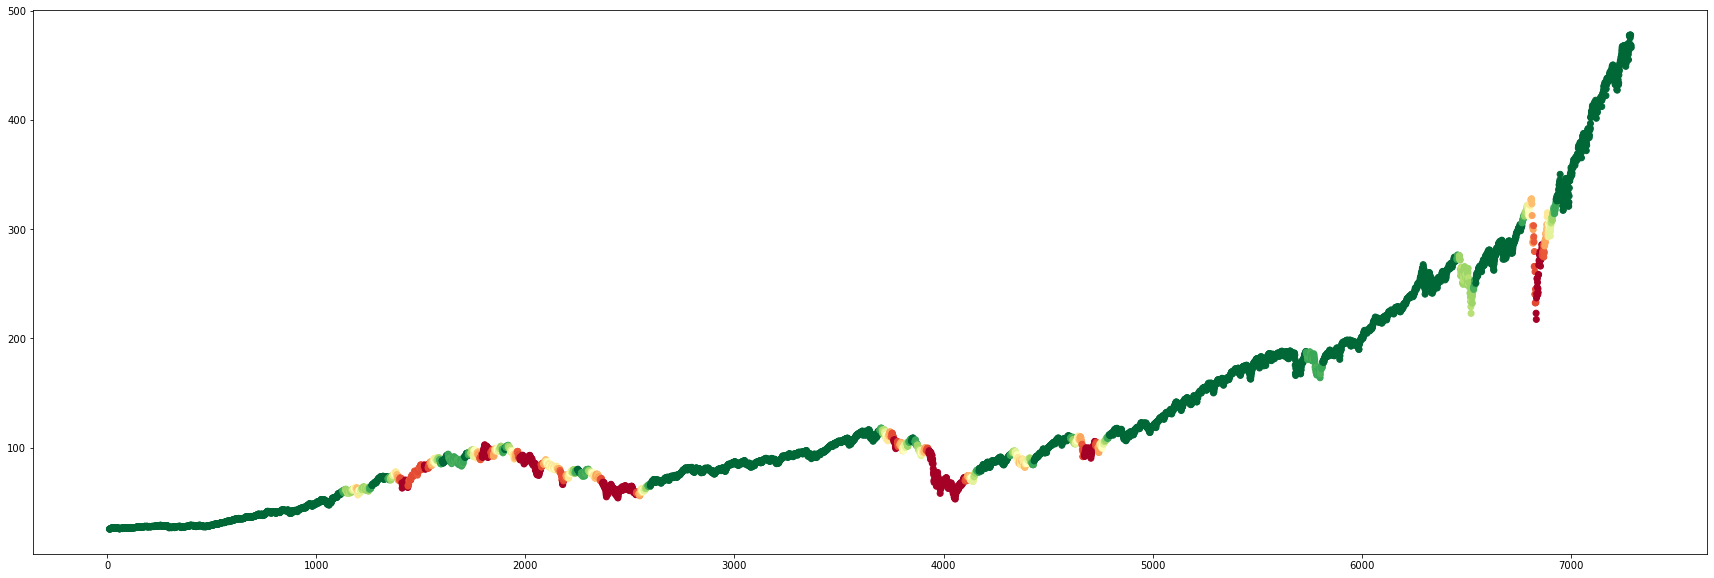

In [7]:
fig = plt.figure(figsize=(30,10))
X = np.arange(spy_df.shape[0])
Y = spy_df['Close'].values
plt.scatter(X, Y, c=1-mu_label, cmap='RdYlGn')